# Sensitivity Analysis with the OpenCL RAMP model

### Import opencl modules

In [1]:
import multiprocessing as mp
import numpy as np
import yaml # pyyaml library for reading the parameters.yml file
import os
import pandas as pd
import unittest
import pickle
import copy

import matplotlib.pyplot as plt

from microsim.opencl.ramp.run import run_headless
from microsim.opencl.ramp.snapshot_convertor import SnapshotConvertor
from microsim.opencl.ramp.snapshot import Snapshot
from microsim.opencl.ramp.params import Params, IndividualHazardMultipliers, LocationHazardMultipliers
from microsim.opencl.ramp.simulator import Simulator
from microsim.opencl.ramp.disease_statuses import DiseaseStatus

import sys
sys.path.append('..')
#import experiments_functions  # For the ones outside the class
from experiments_functions import Functions # Some additional notebook-specific functions required (functions.py)

# Useful for connecting to this kernel
#%connect_info

### Setup params for all runs

Read the parameters file

In [2]:
#PARAMETERS_FILENAME = "default.yml"
#with open(os.path.join("../../","model_parameters", PARAMETERS_FILENAME)) as f:
#    parameters = yaml.load(f, Loader=yaml.SafeLoader)
    
#sim_params = parameters["microsim"]  # Parameters for the dynamic microsim (python)
#calibration_params = parameters["microsim_calibration"]
#disease_params = parameters["disease"]  # Parameters for the disease model (r)

Prepare the parameters for the OpenCL model. (See [main.py](https://github.com/Urban-Analytics/RAMP-UA/blob/052861cc51be5bc1827c85bb827209f0df73c685/microsim/main.py#L262) for an example of how this is done in the code). 

In [2]:
PARAMETERS_FILENAME = "default.yml"  # Creates default parameters using the default.yml file
PARAMS = Functions.create_parameters(
    parameters_file=os.path.join("../../","model_parameters", PARAMETERS_FILENAME))

### Get snapshot path
**NB** this is the path to the OpenCL snapshot file generated by running `microsim/main.py`. To run with new population data just re-run `main.py --opencl` without the `--use-cache` option, so that it regenerates a new snapshot file and writes it to this location.

In [6]:
OPENCL_DIR = "../../microsim/opencl"
SNAPSHOT_FILEPATH = os.path.join(OPENCL_DIR, "snapshots", "cache.npz")
assert os.path.isfile(SNAPSHOT_FILEPATH), f"Snapshot doesn't exist: {SNAPSHOT_FILEPATH}"

## Run OpenCL simulation for multiple repetitions

This shows what happens with the 'default' (manually calibrated) model

In [47]:
iterations = 100
repetitions = 10
num_seed_days = 10
use_gpu=False

# Prepare the function arguments as lists for starmap
l_i = [i for i in range(repetitions)]
l_iterations = [iterations] * repetitions
l_snapshot_filepath = [SNAPSHOT_FILEPATH] * repetitions
l_params = [PARAMS] * repetitions
l_opencl_dir = [OPENCL_DIR] * repetitions
l_num_seed_days = [num_seed_days] * repetitions
l_use_gpu = [use_gpu] * repetitions
l_store_detailed_counts= [True] * repetitions  # If False then model is much quicker but no age breakdown

#results = functions.run_opencl_model_multiprocess(
#    l_i, l_iterations, l_snapshot_filepath, l_params, l_opencl_dir, l_num_seed_days, l_use_gpu)

import itertools  # (only while I can't get multiprocessing to work)
try:
    with mp.Pool(processes=int(os.cpu_count())) as pool:
        #results = pool.starmap(
        results = itertools.starmap(
            Functions.run_opencl_model, zip(
                l_i, l_iterations, l_snapshot_filepath, l_params, l_opencl_dir, l_num_seed_days, l_use_gpu, l_store_detailed_counts
        ))
finally:  # Make sure they get closed (shouldn't be necessary)
    pool.close()

summaries = [x[0] for x in results]
final_results = [x[1] for x in results]
print("Finished")

# To make it convenient to reload later:
pickle.dump( summaries, open( "./summaries.pkl", "wb" ) )

Running simulation 1.
Running simulation 2.
Running simulation 3.
Running simulation 4.
Running simulation 5.
Running simulation 6.
Running simulation 7.
Running simulation 8.
Running simulation 9.
Running simulation 10.
Finished


## Plot output summary data

### Total counts of disease status

In [48]:
def plot_summaries(summaries, plot_type="error_bars"):

    #fig, ax = plt.subplots(1, len(DiseaseStatus), sharey=True)
    fig, ax = plt.subplots(1, 1, figsize=(10,7))
    
    # Work out the number of repetitions and iterations
    iters, reps = _get_iters_and_reps(summaries)
    x = range(iters)

    for d, disease_status in enumerate(DiseaseStatus):
        if disease_status==DiseaseStatus.Susceptible or disease_status==DiseaseStatus.Recovered:
            continue
        # Calculate the mean and standard deviation
        matrix = np.zeros(shape=(reps,iters))
        for rep in range(reps):
            matrix[rep] = summaries[rep].total_counts[d]
        mean = np.mean(matrix, axis=0)
        sd = np.std(matrix, axis=0)
        if plot_type == "error_bars":
            ax.errorbar(x, mean, sd, label=f"{disease_status}" )
        elif plot_type == "lines":
            for rep in range(reps):
                ax.plot(x, matrix[rep], label=f"{disease_status} {rep}", 
                        color=plt.cm.get_cmap("hsv", len(DiseaseStatus))(d) )
                
    ax.legend() 
    ax.set_title("Disease Status")
    ax.set_xlabel("Iteration")
    ax.set_ylabel("Number of cases")

def _get_iters_and_reps(summaries):
    reps = len(summaries)
    iters = len(summaries[0].total_counts[0])
    return (iters, reps)

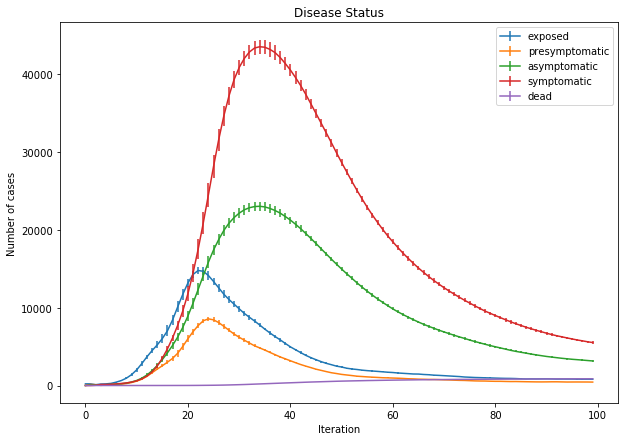

In [50]:
plot_summaries(summaries=summaries, plot_type="error_bars")

In [ ]:
#plot_summaries(summaries=summaries, plot_type="lines")

### Disease statuses by age

In [ ]:
   
def plot_disease_status_by_age(summaries):

    #fig, ax = plt.subplots(1, len(DiseaseStatus), sharey=True)
    fig, ax = plt.subplots(int(len(DiseaseStatus)/2), int(len(DiseaseStatus)/2), 
                           figsize=(15,11), tight_layout=True)
    iters, reps = _get_iters_and_reps(summaries)
    x = range(iters)
    age_thresholds = summaries[0].age_thresholds

    for d, disease_status in enumerate(DiseaseStatus):
        lower_age_bound = 0
        for age_idx in range(len(age_thresholds)):
            matrix = np.zeros(shape=(reps, iters))
            for rep in range(reps):
                #matrix[age_idx][rep][it] = summaries[rep].age_counts[str(disease_status)][age_idx][it]
                matrix[rep] = summaries[rep].age_counts[str(disease_status)][age_idx]
            mean = np.mean(matrix, axis=0)
            sd = np.std(matrix, axis=0)
            ax.flat[d].errorbar(x, mean, sd, label=f"{lower_age_bound} - {age_thresholds[age_idx]}" )
            lower_age_bound = age_thresholds[age_idx]
                
            ax.flat[d].legend() 
            ax.flat[d].set_title(f"{str(disease_status)}")
            ax.flat[d].set_xlabel("Iteration")
            ax.flat[d].set_ylabel("Number of cases")
    #fig.set_title(f"Num {disease_status} people by age group")

In [ ]:
plot_disease_status_by_age(summaries)

### Plot MSOA geodata

#### Load MSOA shapes

In [ ]:
from microsim.load_msoa_locations import load_osm_shapefile, load_msoa_shapes
import pandas as pd

data_dir = ("../devon_data")

osm_buildings = load_osm_shapefile(data_dir)

devon_msoa_shapes = load_msoa_shapes(data_dir, visualize=False)

devon_msoa_shapes.plot()
plt.show()

In [ ]:
import pandas as pd

def plot_msoa_choropleth(msoa_shapes, summary, disease_status, timestep):
    # get dataframes for all statuses
    msoa_data = summary.get_area_dataframes()
    
    msoa_data_for_status = msoa_data[disease_status]

    # add "Code" column so dataframes can be merged
    msoa_data_for_status["Code"] = msoa_data_for_status.index
    msoa_shapes = pd.merge(msoa_shapes, msoa_data_for_status, on="Code")

    msoa_shapes.plot(column=f"Day{timestep}", legend=True)
    plt.show()

### Plot disease status by MSOA for a given timestep and status

In [ ]:
disease_status = "exposed"

plot_msoa_choropleth(devon_msoa_shapes, summaries[0], disease_status, 99)

## Observation Data

Read the real observations (number of hospital admissions in Devon) that will be used to calibrate the model. See the [README](./observation_data/README.md) for information about how these observations were obtained. They aren't the raw cases, it's actually a model that was fitted to the lagged cases.

In [5]:
observations = pd.read_csv("observation_data/gam_cases.csv", header=0, names=["Day", "Cases"], )
observations

,Day,Cases
0,1,10
1,2,11
2,3,13
3,4,16
4,5,18
...,...,...
98,99,10
99,100,9
100,101,9
101,102,8


## Calculating Error: Fitness Function

To calibrate the model we need a fitness function that tells us, for a given result, how similar it is to the observations. There are lots of ways to do this. For now, just take the **Euclidean distance (L2 norm)** between the observed number of cases and the simulated number of cases.

Note that the model is seeded using the first few days of cases, so at the beginning of a run the simulated data will be identical to the observations. This doesn't matter though because the relative difference between different parameter combinations will be the same regardless.

In [5]:
# The fitness function is defined in experiments_functions.py (so that it can be tested)
fit = Functions.fit_l2

## Calibration Parameters

Which parameters will we try to calibrate on?

To begin with lets just try the `current_risk_beta` (a general multiplier for risk at locations).

Create a function that takes a value of that parameter as an argument, runs a model, and returns the result (the number of cases per day).

In [7]:
ITERATIONS = 100  # Number of iterations to run for
NUM_SEED_DAYS = 10  # Number of days to seed the population
USE_GPU = False
STORE_DETAILED_COUNTS = False
REPETITIONS = 10 

assert ITERATIONS < len(observations), \
    f"Have more iterations ({iterations}) than observations ({len(observations)})."


NameError: name 'observations' is not defined

In [168]:
def run_model_current_risk_beta(x):
    """Run a model REPETITIONS times using the provided value for the current_risk_beta. 
    Return the mean fitness across all model runs"""
    params = create_parameters(current_risk_beta=x)
    
    # Prepare the function arguments. We need one set of arguments per repetition
    l_i = [i for i in range(REPETITIONS)]
    l_iterations = [ITERATIONS] * REPETITIONS
    l_snapshot_filepath = [SNAPSHOT_FILEPATH] * REPETITIONS
    l_params = [PARAMS] * REPETITIONS
    l_opencl_dir = [OPENCL_DIR] * REPETITIONS
    l_num_seed_days = [NUM_SEED_DAYS] * REPETITIONS
    l_use_gpu = [use_gpu] * REPETITIONS
    l_store_detailed_counts= [STORE_DETAILED_COUNTS] * REPETITIONS  # If False then model is much quicker but no age breakdown
    
    results = Functions.run_opencl_model_multi(
        multiprocess=False,
        opencl_dir=os.path.join("../..", "microsim", "opencl"),
        snapshot_filepath=os.path.join(opencl_dir, "snapshots", "cache.npz"),
            multiprocess=False
        zip(l_i, l_iterations, l_snapshot_filepath, l_params, l_opencl_dir, l_num_seed_days, l_use_gpu, l_store_detailed_counts)
    )
    
    summaries = [x[0] for x in results]
    final_results = [x[1] for x in results]
    
    sim = experiments_functions.get_mean_total_counts(summaries, DiseaseStatus.Exposed.value)
    
    # Can get the total cases from the Summary object

    # Compare these to the observations
    obs = observations.loc[:iterations-1,"Cases"].values
    assert len(sim) == len(obs)
    return fit(sim,obs)
    #return ( fit(sim,obs), sim, obs )

In [169]:
#(fitness, sim, obs) = run_model_current_risk_beta(0.001)
fitness = run_model_current_risk_beta(0.001)

print(fitness)
#list(zip(obs,sim))

Running simulation 1.
1098.678751956185


### Calibration Method: XXXX

Lots of different methods are avialbale. Simulated annealing? Latin-Hypercube sampling? GA? ABC?



Start with a simple minimisation algorithm [Nelder-Mead Simplex algorithm](https://docs.scipy.org/doc/scipy/reference/tutorial/optimize.html#nelder-mead-simplex-algorithm-method-nelder-mead)

In [ ]:
from scipy.optimize import minimize



x0 = np.array([1.3, 0.7, 0.8, 1.9, 1.2])

res = minimize(rosen, x0, method='nelder-mead',

               options={'xatol': 1e-8, 'disp': True})

# Unit Tests

I've not put tests into a notebook before. Not sure how well this will work. Uses a small ipython extension: https://github.com/akaihola/ipython_pytest/